# Task 6.6 Sourcing & Analyzing Time Series Data

## Contents
    01.Importing Libraries & Data
    02.Subsetting, Wrangling, and Cleaning Time-Series Data
    03.Time-Series Analysis: Decomposition
    04.Testing for Stationarity
    05.Stationarizing the Blockchain Bitcoin Market Price USD Data

### 01.Importing Libraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm #Using .api imports the public access version of statsmodels, a library that handles statistical models.
import os
import warnings 
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
#configure API key 
quandl.ApiConfig.api_key='WUcPiy-_kwLYshVn6CmF'

In [3]:
#importing the Blockchain "Bitcoin Market Price USD" variable.
data=quandl.get('BCHAIN/MKPRU')

In [4]:
data.head()

,Value
Date,
2009-01-02,0.0
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
2009-01-06,0.0


In [5]:
data.shape

(5048, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

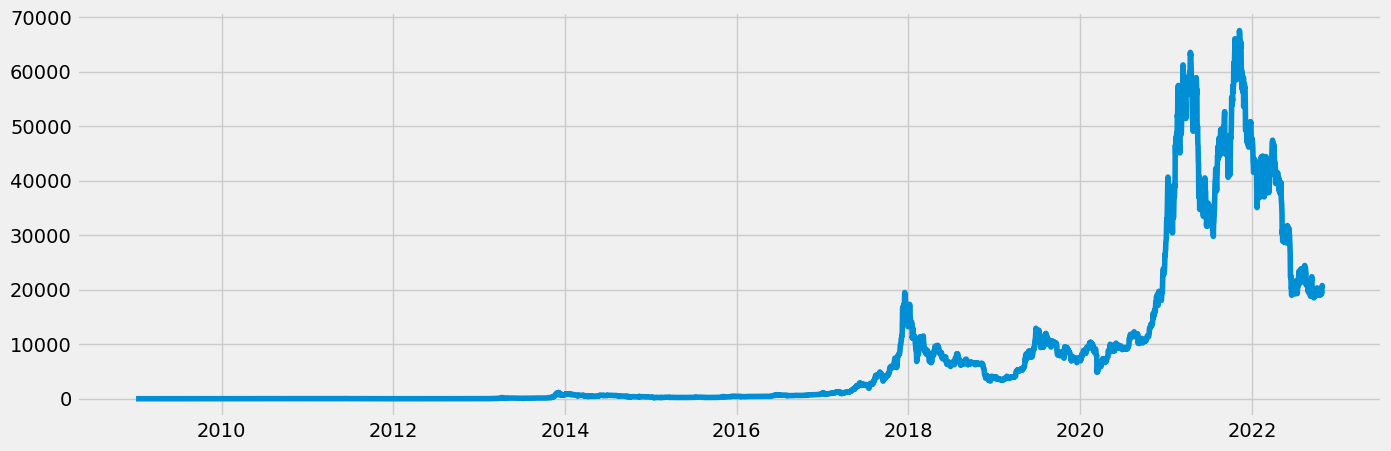

In [8]:
#plotting the data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### 02.Subsetting, Wrangling, and Cleaning Time-Series Data

In [24]:
#resetting index so that the "Date" column can be used as a filter
data_2=data.reset_index()

In [25]:
data_2.head()

,Date,Value
0,2009-01-02,0.0
1,2009-01-03,0.0
2,2009-01-04,0.0
3,2009-01-05,0.0
4,2009-01-06,0.0


In [26]:
data_sub=data_2.loc[(data_2['Date'] >= '2017-01-01')]

I made a subset of the data starting in 2017 because the data points were essentially a flat line up until that point.

In [27]:
data_sub.shape

(2127, 2)

In [28]:
data_sub.head()

,Date,Value
2921,2017-01-01,997.72
2922,2017-01-02,1015.97
2923,2017-01-03,1013.42
2924,2017-01-04,1126.76
2925,2017-01-05,994.67


In [29]:
#removing daily entries and changing to month/year for later decomposition
import datetime
data_sub['year']=pd.DatetimeIndex(data_sub['Date']).year
data_sub['month']=pd.DatetimeIndex(data_sub['Date']).month
data_sub['year_month']=pd.to_datetime(data_sub.year.astype(str)+'-'+data_sub.month.astype(str))

In [30]:
data_sub2=data_sub.groupby('year_month').agg({'Value':['mean']})

In [31]:
#checking for missing values
data_sub2.isnull().sum() #no missing values!

Value  mean    0
dtype: int64

In [32]:
#checking for duplicates
dups=data_sub2.duplicated()
dups.sum() #no duplicates!

0

In [33]:
data_sub2

,Value
,mean
year_month,
2017-01-01,913.659045
2017-02-01,1057.745139
2017-03-01,1133.317805
2017-04-01,1210.692140
2017-05-01,1882.522766
...,...
2022-06-01,24756.532333
2022-07-01,21417.305161


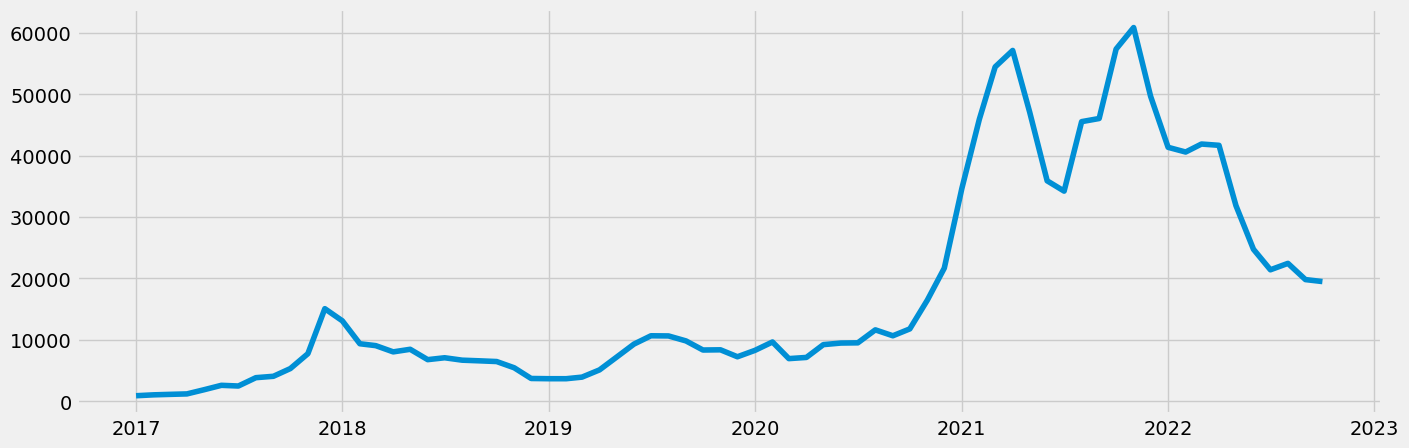

In [34]:
#plotting the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub2)

### 03.Time-Series Analysis: Decomposition

In [35]:
#decomposing the time series using an additive model
decomposition=sm.tsa.seasonal_decompose(data_sub2, model='additive')

In [36]:
from pylab import rcParams #this will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

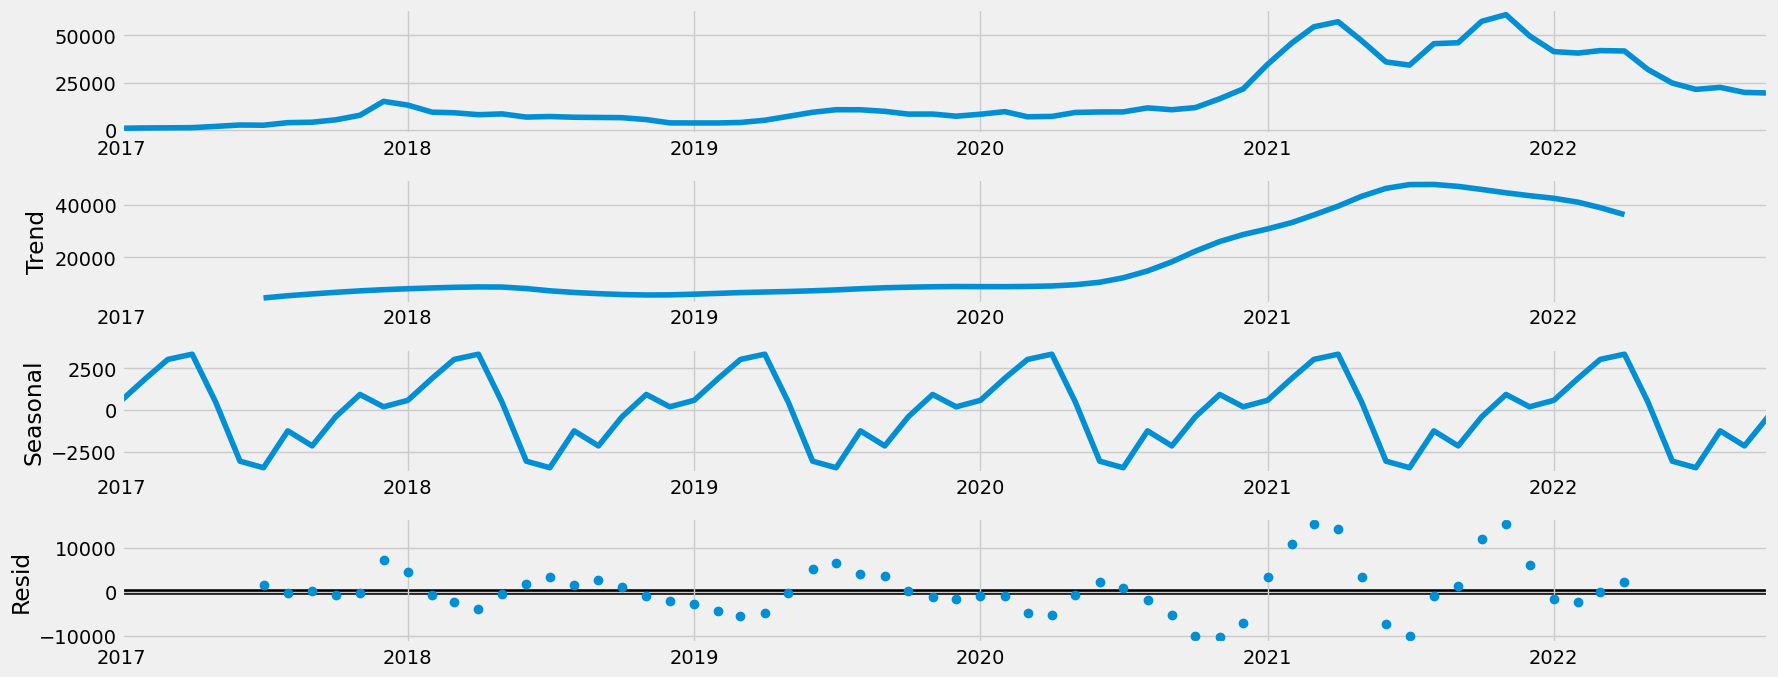

In [37]:
#plotting the separate components
decomposition.plot()
plt.show()

The trend lines show a general increase in price of bitcoin with a drop around 2020 and then again recently it has begun to decline in value. 

The seasonal line has a repeating pattern which would indicate seasonality affects the value.

### 04.Testing for Stationarity

In [38]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.596161
p-value                         0.485522
Number of Lags Used             2.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the **test statistic** to the **critical value** of the corresponding significance level.

If the **test statistic** is larger than the **critical value**, one can’t reject the null hypothesis. If the **test statistic** is smaller than the **critical value**, the null hypothesis could be rejected.

In this case, considering a significance level of 5%, the **Critical Value of 5%** has a value of -2.905755. This is smaller than the **test statistic**, which is -1.596161, which means that the null hypothesis cannot be rejected.

This also means that the data is non-stationary.

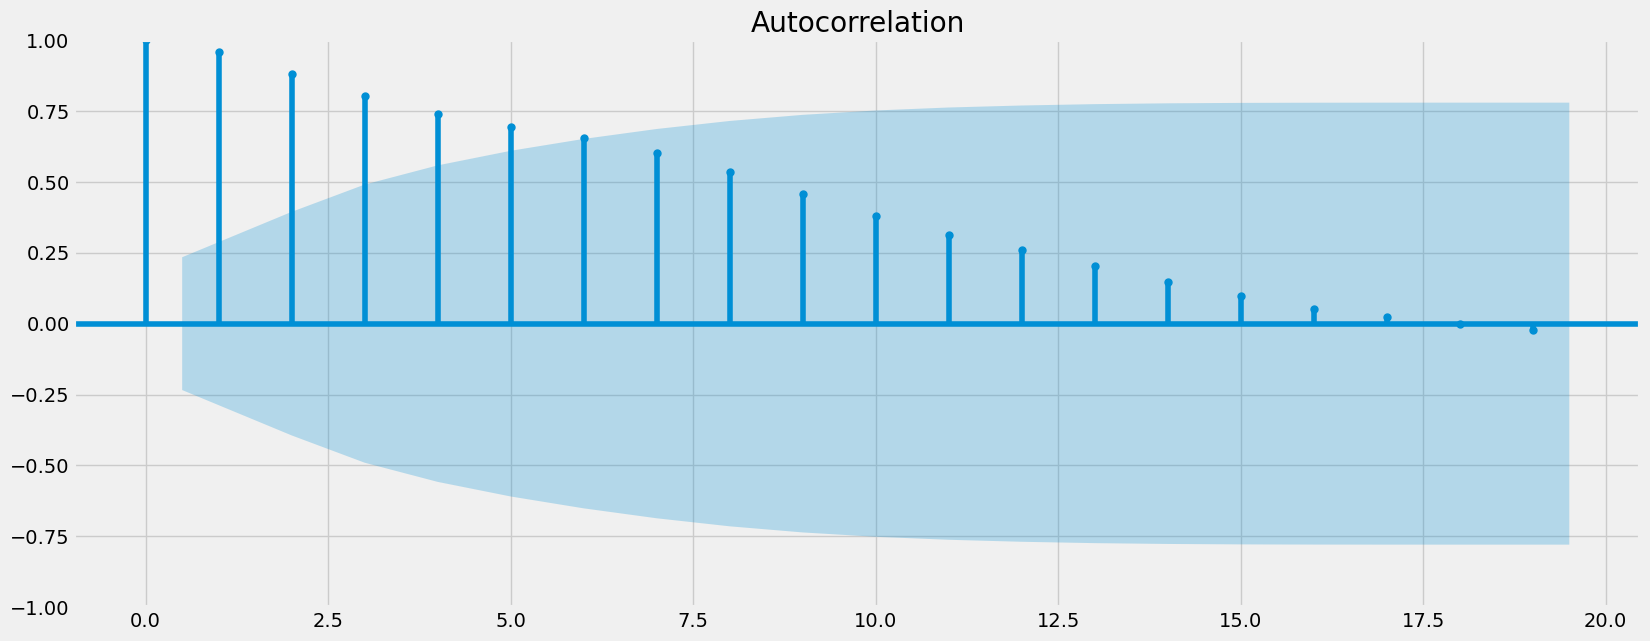

In [39]:
#Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #import the autocorrelation and partial correlation plots

plot_acf(data_sub2)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is non-stationary.

### 05.Stationarizing the Blockchain Bitcoin Market Price USD Data

In [40]:
data_diff=data_sub2-data_sub2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [41]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
#You need to remove these or you won't be able to run the Dickey-Fuller test.

In [42]:
data_diff.head()

,Value
,mean
year_month,
2017-02-01,144.086094
2017-03-01,75.572666
2017-04-01,77.374335
2017-05-01,671.830626
2017-06-01,726.137418


In [43]:
data_diff.columns

MultiIndex([('Value', 'mean')],
           )

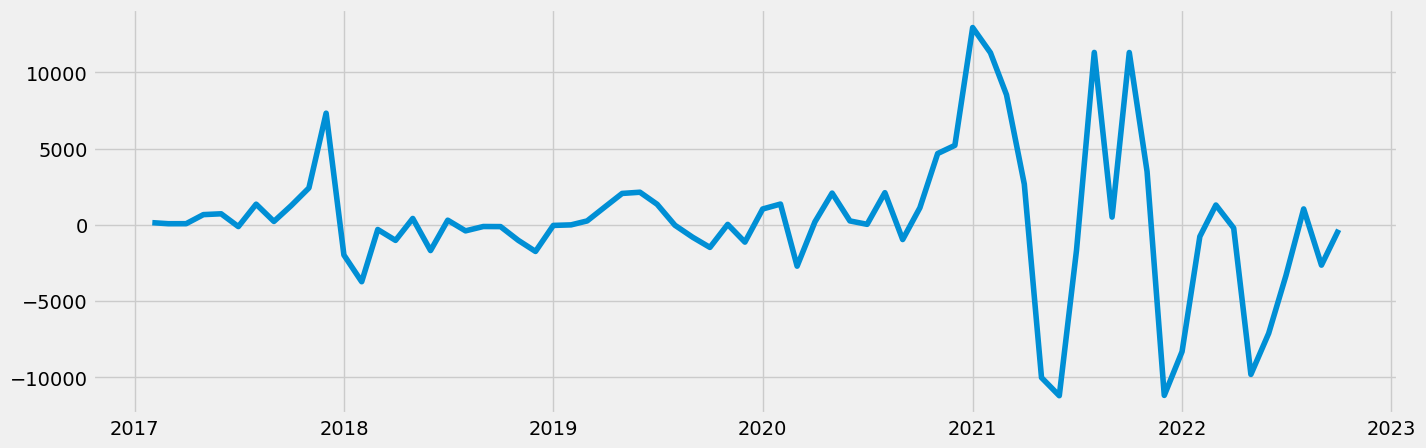

In [44]:
#Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [45]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.460533
p-value                         0.000003
Number of Lags Used             1.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


These results show the data is now **stationary** because the **test statistic** -5.460533 is smaller than the **critical value (5%)** -2.905755 and the **p-value** is smaller than 0.05. The result is significant and the null hypothesis can be rejected.

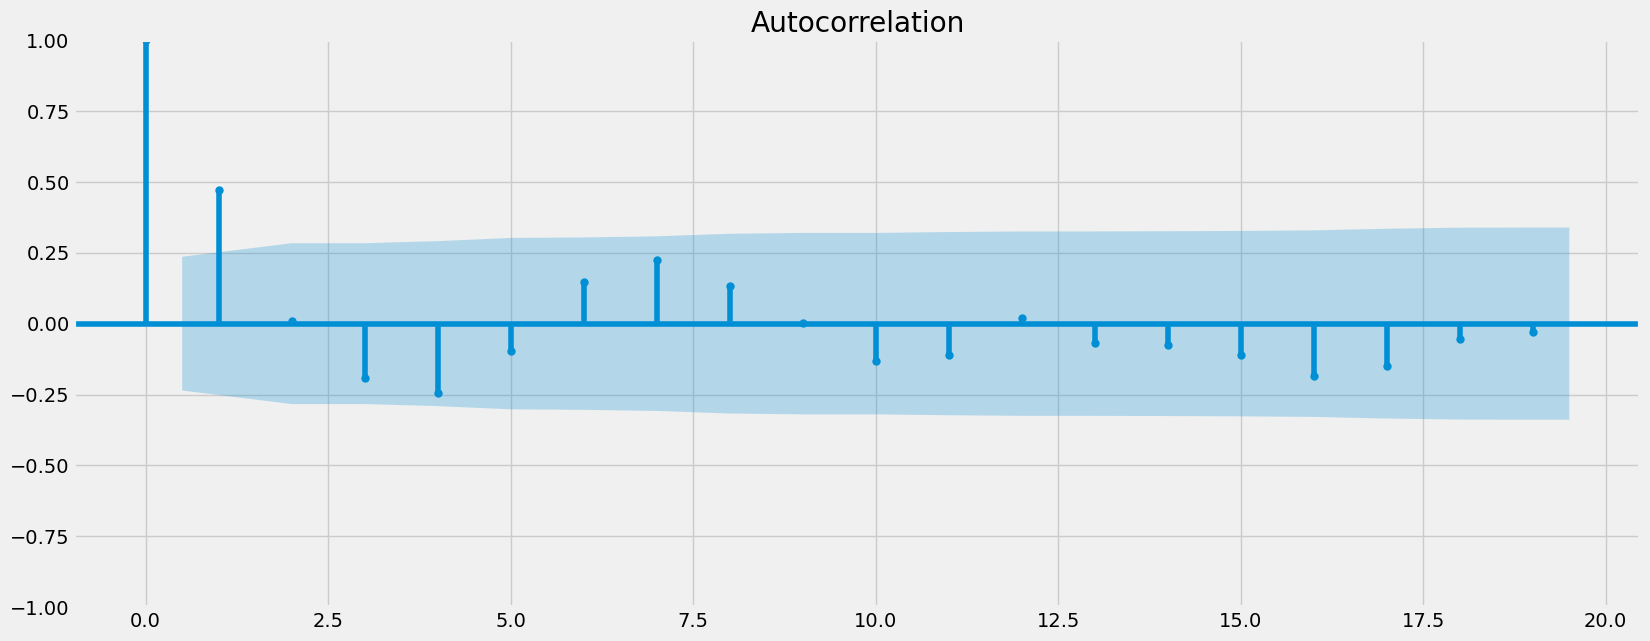

In [46]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has improved. The stationary is strong due to only 1 vertical line going above the confidence interval.